<a href="https://colab.research.google.com/github/Pmskabir1234/Torch/blob/main/Rice_type_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saadkabir0108
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 1.12GB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'   #to detect gpu
print(device)

cuda


In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [50]:
data_df = data_df.dropna()
data_df.drop(['id'], axis = 1, inplace = True)

In [51]:
og_df = data_df.copy()

#to normalize the values of each column  in the range(0,1)
for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543,0.0
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661,0.0
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830,0.0
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874,0.0


In [52]:
X = data_df.drop("Class", axis = 1).to_numpy()
y = data_df['Class'].to_numpy()

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


Pytorch itself is like huge ecosystem that consists of many funtions,
and other things. But Pytorch does not sees the data as we see in pandas or numpy. For the convenience of use we will be crating an object that will inherit from Datasets which we imported earlier. Let's cook to understand what I am tryna say....

In [54]:
class dataset(Dataset):
  def __init__(self, X,y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.y = torch.tensor(y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]



In [55]:
training_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

In tensorflow we have seen that when we train the model, we use batch_size to specify what amout of data will be loaded at time for training.Here we will do that task using Dataloader.

In [56]:
train_data_loader = DataLoader(training_data, batch_size = 16, shuffle = True)
test_data_loader = DataLoader(test_data, batch_size = 16, shuffle = True)
val_data_loader = DataLoader(validation_data, batch_size = 16, shuffle = True)

#for quick visualisation of one loop
for x,y in train_data_loader:
  print(x)
  print("========")
  print(y)
  break

tensor([[0.9599, 0.9032, 0.9233, 0.9181, 0.9127, 0.9798, 0.6466, 0.7793, 0.8668,
         0.5550],
        [0.5762, 0.8286, 0.6130, 0.9752, 0.5474, 0.7591, 0.8907, 0.6599, 0.7257,
         0.7668],
        [0.8501, 0.8292, 0.8893, 0.9056, 0.8101, 0.9220, 0.6880, 0.7370, 0.8583,
         0.5290],
        [0.8713, 0.8718, 0.8694, 0.9241, 0.8237, 0.9334, 0.8700, 0.7556, 0.8370,
         0.5690],
        [0.5643, 0.8014, 0.6215, 0.9692, 0.5415, 0.7512, 0.5607, 0.6424, 0.7500,
         0.7316],
        [0.8503, 0.8566, 0.8635, 0.9215, 0.8080, 0.9221, 0.9026, 0.7415, 0.8482,
         0.5629],
        [0.7438, 0.8052, 0.8072, 0.9229, 0.7069, 0.8624, 0.8320, 0.6912, 0.8538,
         0.5660],
        [0.5674, 0.7552, 0.6664, 0.9491, 0.5455, 0.7532, 0.5768, 0.6413, 0.7566,
         0.6429],
        [0.5881, 0.7929, 0.6501, 0.9612, 0.5610, 0.7668, 0.6108, 0.6456, 0.7736,
         0.6919],
        [0.6575, 0.6600, 0.8809, 0.8265, 0.6371, 0.8109, 0.7568, 0.6343, 0.8961,
         0.4251],
        [0

In [79]:
HIDDEN_NEURONS = 10
class model(nn.Module):
  def __init__(self):
    super(model,self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)

    return x

model = model().to(device)




In [80]:
summary(model, (X.shape[1],))   #syntax summary(model_name, (input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [81]:
criterion = nn.BCELoss()   #binarycrossentropy for binary classification
optimizer = Adam(model.parameters(), lr = 1e-3)

In [82]:
total_train_loss_plot = []
total_train_acc_plot = []
total_val_loss_plot = []
total_val_acc_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_data_loader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()     #for backward propagatopn
    optimizer.step()          # "optimizer, we have the losses..please take a step to update weights"
    optimizer.zero_grad()     #for convergence of model

  # now, for validation we wont change the weights, we will use the training weights of the
  # model to see how is that working on the unseen data.
  with torch.no_grad():
    for data in val_data_loader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()
      total_acc_val += acc

  total_train_loss_plot.append(round(total_loss_train/100, 4))
  total_train_acc_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_val_loss_plot.append(round(total_loss_val/1000, 4))
  total_val_acc_plot.append(round(total_acc_val/training_data.__len__() * 100, 4))

  print(f"""Epoch no: {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)}
        Validation Loss: {round(total_loss_val/1000, 4)} Validation Accuracy: {round(total_acc_val/training_data.__len__()*100, 4)}
        """)




Epoch no: 1 Train Loss: 0.4469 Train Accuracy: 77.728
        Validation Loss: 0.053 Validation Accuracy: 21.0936
        
Epoch no: 2 Train Loss: 0.1395 Train Accuracy: 98.2088
        Validation Loss: 0.0183 Validation Accuracy: 21.0229
        
Epoch no: 3 Train Loss: 0.065 Train Accuracy: 98.4759
        Validation Loss: 0.012 Validation Accuracy: 21.0621
        
Epoch no: 4 Train Loss: 0.0472 Train Accuracy: 98.6016
        Validation Loss: 0.0096 Validation Accuracy: 21.1171
        
Epoch no: 5 Train Loss: 0.0402 Train Accuracy: 98.5623
        Validation Loss: 0.0089 Validation Accuracy: 21.1014
        
Epoch no: 6 Train Loss: 0.0367 Train Accuracy: 98.6409
        Validation Loss: 0.0082 Validation Accuracy: 21.1171
        
Epoch no: 7 Train Loss: 0.035 Train Accuracy: 98.6173
        Validation Loss: 0.008 Validation Accuracy: 21.1093
        
Epoch no: 8 Train Loss: 0.0337 Train Accuracy: 98.6566
        Validation Loss: 0.0079 Validation Accuracy: 21.1093
        
Epoch 

In [83]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0
  for data in test_data_loader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels).item()
    total_test_loss += batch_loss

    acc = ((prediction).round() == labels).sum().item()
    total_test_acc +=  acc
  print(f"Accuracy: {round(total_test_acc/test_data.__len__()*100, 4)}")


Accuracy: 98.827


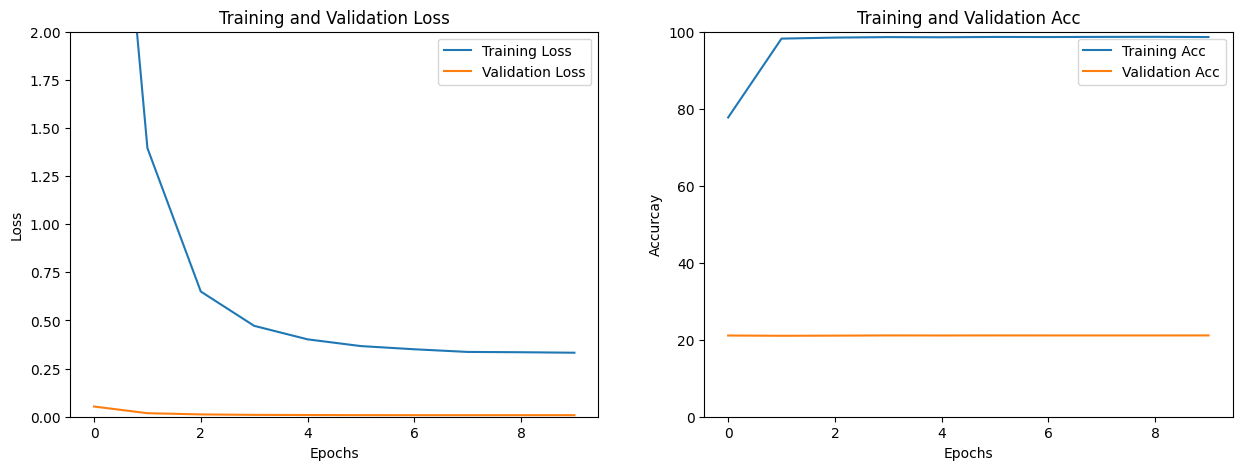

In [84]:
fig, axs = plt.subplots(1,2,figsize = (15,5))
axs[0].plot(total_train_loss_plot, label='Training Loss')
axs[0].plot(total_val_loss_plot, label='Validation Loss')
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()
axs[1].plot(total_train_acc_plot, label='Training Acc')
axs[1].plot(total_val_acc_plot, label='Validation Acc')
axs[1].set_title("Training and Validation Acc")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Accurcay')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

Inference means to use a pretrained model, here is how you can use your model for prediction

In [85]:
area = 4319/og_df['Area'].abs().max()
MajorAxisLength = 90/og_df['MajorAxisLength'].abs().max()
MinorAxisLength = 59.0745/og_df['MinorAxisLength'].abs().max()
Eccentricity = 0.701/og_df['Eccentricity'].abs().max()
ConvexArea = 4519/og_df['ConvexArea'].abs().max()
EquivDiameter = 73.094/og_df['EquivDiameter'].abs().max()
Extent = 0.78/og_df['Extent'].abs().max()
Perimeter = 269.90/og_df['Perimeter'].abs().max()
Roundness = 0.8212/og_df['Roundness'].abs().max()
AspectRation = 1.509/og_df['AspectRation'].abs().max()

infer_prediction = model(torch.tensor([area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation], dtype=torch.float32).to(device))
print(round(infer_prediction.item()))

0
